## Импорты и настройка окружения

In [74]:
import os
import time
import re
from enum import Enum
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import mlflow
from mlflow.models.signature import infer_signature

from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm, trange
from pyngrok import ngrok



In [75]:
# os.environ["GIT_PYTHON_REFRESH"] = "quiet"
# import git
torch.cuda.is_available()

True

In [76]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


## Трансформация

In [77]:
distortion_scale = 0.2

In [78]:
class ToCenter(torch.nn.Module):
    def __init__(
        self,
        size: int = 28
    ):
        super(ToCenter, self).__init__()

        assert size % 2 == 0, 'Size must be even'
        
        self._size = size
        self._offset = size // 2

    def forward(self, img):
        
        img_array = np.array(img)
        rows = np.any(img_array > 0, axis=1)
        cols = np.any(img_array > 0, axis=0) 
   
        row_nonzero = np.where(rows)[0]
        col_nonzero = np.where(cols)[0]

        if row_nonzero.size: 
            top, bottom = row_nonzero[[0, -1]]
        else:  # изображение полностью из нулей
            top, bottom = 0, 0

        if col_nonzero.size:
            left, right = col_nonzero[[0, -1]]
        else:
            left, right = 0, 0

        resize_img=img_array[top:bottom+1, left:right+1] / 255
        result = np.zeros((28, 28))

        row_start = int(self._offset - (bottom - top) / 2)
        row_end = int(self._offset + (bottom - top) / 2 + 1)
        col_start = int(self._offset  - (right - left) / 2)
        col_end = int(self._offset + (right - left) / 2 + 1)
        result[row_start: row_end, col_start:col_end] = resize_img
        

        img_result = Image.fromarray(result)
        
        return img_result
   

In [79]:
class Translate(torch.nn.Module):
    def __init__(
        self,
        size: int = 28
    ):
        super(Translate, self).__init__()

        assert size % 2 == 0, 'Size must be even'
        
        self._size = size
        self._offset = size // 2

    def forward(self, img):
        
        img_array = np.array(img)
        rows = np.any(img_array > 0, axis=1)
        cols = np.any(img_array > 0, axis=0) 
   
        row_nonzero = np.where(rows)[0]
        col_nonzero = np.where(cols)[0]

        if row_nonzero.size: 
            top, bottom = row_nonzero[[0, -1]]
            
        else:  # изображение полностью из нулей
            top, bottom = 0, 0

        if col_nonzero.size:
            left, right = col_nonzero[[0, -1]]
        else:
            left, right = 0, 0

        resize_img = img_array[top:bottom+1, left:right+1]# / 255
        result = np.zeros((self._size, self._size))
        
        row_start = random.randint(0, 28 - (bottom - top + 1))
        row_end = bottom - top + row_start
        col_start =  random.randint(0, 28 - (right - left + 1))
        col_end = right - left + col_start

        result[row_start: row_end + 1, col_start:col_end + 1] = resize_img
        
        img_result = Image.fromarray(result)
        
        return img_result
   

In [80]:
transform = transforms.Compose([
    ToCenter(),
    transforms.RandomChoice([transforms.RandomRotation(degrees=30.0), Translate(28)], p=[0.5, 0.5]),
    #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    #transforms. ElasticTransform(alpha=50.0 ),
    #transforms.RandomRotation(degrees=10.0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 1)),
    #transforms.RandomPerspective(p=0.9, distortion_scale=distortion_scale),
    #transforms.RandomResizedCrop(size=(28, 28),scale=(0.7, 0.8), ratio=(0.7, 0.8)),
    transforms.ToTensor()
])


In [81]:
transform_test = transforms.Compose([
    ToCenter(),
    transforms.ToTensor()
])

In [82]:
def get_transform():
    try:
        transform
    except NameError:
        return transforms.Compose([transforms.ToTensor()])
    else:
        return transform

In [83]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt_ax.imshow(inp)
    
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Погрузка и настройка данных

In [84]:
generator1 = torch.Generator().manual_seed(42)

dataset_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataset_train_augm = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataset = torch.utils.data.ConcatDataset(
    [dataset_train, dataset_train_augm]
)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_test)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator1)

DEVICE = torch.device("cuda")

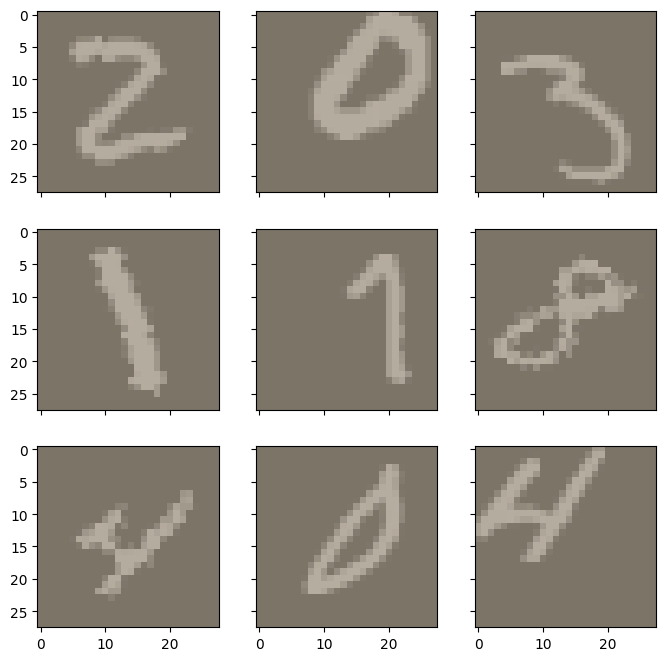

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_train_augm[random_characters]
    
    imshow(im_val.data.cpu(), plt_ax=fig_x)

## Методы обучения, предсказания и оценки

In [86]:
class Timer:
    def __enter__(self):
        self._start = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self._end = time.time()

    def __str__(self):
        num = self.float_round()
        return f'{num} seconds'
    
    def float_round(self, cnt_numbers: int = 4) -> float:
        return round(self._end - self._start, cnt_numbers)

In [87]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data_count = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data_count += inputs.size(0)

    train_loss = running_loss / processed_data_count
    train_acc = running_corrects.cpu().numpy() / processed_data_count

    return train_loss, train_acc

In [88]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [89]:
def train(train_files, val_files, model, epochs: int, batch_size: int, num_samples: int):
    train_sampler=torch.utils.data.RandomSampler(train_dataset, num_samples=num_samples)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle=True,sampler=train_sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [90]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            if isinstance(inputs, tuple) or isinstance(inputs, list) and len(inputs) == 2:
                # if the loader is really loader, then it returns tuple(X, y)
                inputs = inputs[0]

            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Архитектуры

### Архитектура EnsNet

In [91]:
class EnsNet(nn.Module):
  def __init__(self, num_classes=10):
      super(EnsNet, self).__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.35),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(512, 1024, kernel_size=3),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        
      )
      self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
      self.classifier_major = nn.Linear(216, num_classes)
      self.classifiers = nn.ModuleList([
          nn.Linear(216, num_classes)
          for _ in range(10)
      ])
      self.weights = nn.Parameter(torch.ones(11) / 11, requires_grad=True)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x_major = self.classifier_major(x[:, :216])
    x_rest = [classifier(x[:, 216 * i :216 * (i + 1) ]) for i, classifier in enumerate(self.classifiers)]
    all_x = torch.stack([x_major] + x_rest, dim=1)
    weighted_x = torch.sum(all_x * self.weights.view(1, -1, 1), dim=1)
    return weighted_x

### AlexNet

In [40]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

### VGG8

In [39]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=(3,3)),  nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(5184, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### ResNet

In [17]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
  def forward(self, x):
    out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = nn.ReLU(inplace=True)(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 16

    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      self._make_layer(16, 2, stride=1),
      self._make_layer(32, 2, stride=2),
      self._make_layer(64, 2, stride=2),
      self._make_layer(128, 2, stride=2),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(start_dim=1),
      nn.Linear(128, num_classes)
  )
    self._initialize_weights()

  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

### LeNet

In [92]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(3136, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### Подгрузка модели

In [93]:
class NNNetEnum(Enum):
    ens_net = 1
    alex_net = 2
    vgg8 = 3
    res_net = 4
    le_net = 5

In [94]:
def get_nn_model(nn_model: NNNetEnum):
    model_class = None
    if nn_model == NNNetEnum.ens_net:
        model_class =  EnsNet
    if nn_model == NNNetEnum.alex_net:
        model_class =  AlexNet
    if nn_model == NNNetEnum.vgg8:
        model_class =  VGG8
    if nn_model == NNNetEnum.res_net:
        model_class =  ResNet
    if nn_model == NNNetEnum.le_net:
        model_class =  LeNet

    if model_class is None:
        raise Exception(f'The passed architecture {nn_model} was not found. Check enum conditions.')
    
    return model_class().to(DEVICE)

## Тесты архитектур

In [105]:
simple_cnn = get_nn_model(NNNetEnum.le_net)

In [106]:
epoch = 10
batch_size = 64
num_samples = 5000

In [107]:
with Timer() as train_timer:
    history = train(train_dataset, val_dataset, model=simple_cnn, epochs=epoch, batch_size=batch_size, num_samples=num_samples)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 0.3680958793312311


epoch:  10%|███████▌                                                                    | 1/10 [00:22<03:20, 22.25s/it]


Epoch 001 train_loss: 0.3681     val_loss 0.2013 train_acc 0.8847 val_acc 0.9383
loss 0.15065886152349411


epoch:  20%|███████████████▏                                                            | 2/10 [00:44<02:55, 21.96s/it]


Epoch 002 train_loss: 0.1507     val_loss 0.1337 train_acc 0.9534 val_acc 0.9600
loss 0.11583079675367723


epoch:  30%|██████████████████████▊                                                     | 3/10 [01:05<02:33, 21.93s/it]


Epoch 003 train_loss: 0.1158     val_loss 0.1088 train_acc 0.9649 val_acc 0.9665
loss 0.09722732781432569


epoch:  40%|██████████████████████████████▍                                             | 4/10 [01:27<02:11, 21.88s/it]


Epoch 004 train_loss: 0.0972     val_loss 0.1022 train_acc 0.9704 val_acc 0.9679
loss 0.08751402696454898


epoch:  50%|██████████████████████████████████████                                      | 5/10 [01:49<01:49, 21.91s/it]


Epoch 005 train_loss: 0.0875     val_loss 0.0943 train_acc 0.9731 val_acc 0.9718
loss 0.07989833848690614


epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [02:11<01:27, 21.86s/it]


Epoch 006 train_loss: 0.0799     val_loss 0.0826 train_acc 0.9760 val_acc 0.9758
loss 0.07635834106178178


epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [02:33<01:05, 21.92s/it]


Epoch 007 train_loss: 0.0764     val_loss 0.0799 train_acc 0.9767 val_acc 0.9754
loss 0.06810745471258027


epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [02:55<00:43, 21.87s/it]


Epoch 008 train_loss: 0.0681     val_loss 0.0825 train_acc 0.9797 val_acc 0.9741
loss 0.0687880326504819


epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [03:17<00:21, 21.85s/it]


Epoch 009 train_loss: 0.0688     val_loss 0.0859 train_acc 0.9793 val_acc 0.9751
loss 0.062933871405432


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [03:38<00:00, 21.88s/it]


Epoch 010 train_loss: 0.0629     val_loss 0.0750 train_acc 0.9806 val_acc 0.9781


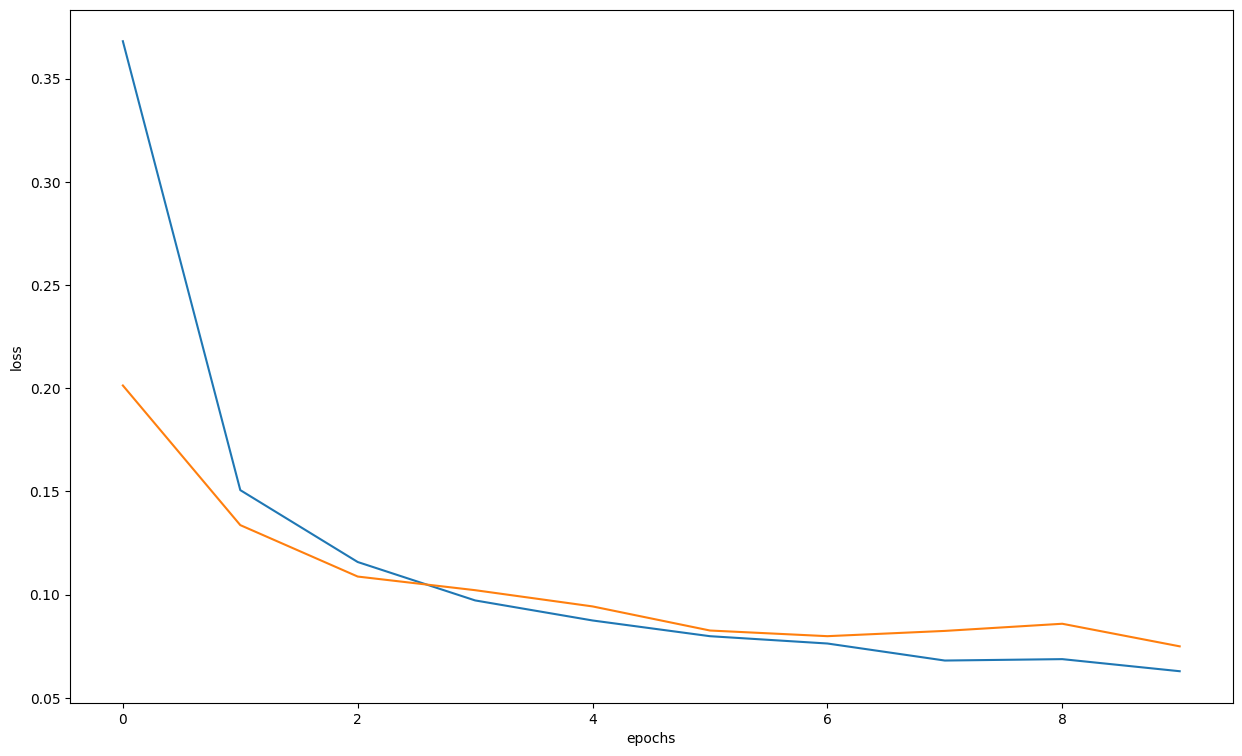

In [108]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [109]:
test_img = [test_dataset[i][0].unsqueeze(0) for i in range(len(test_dataset))]

with Timer() as test_timer:
    test_pred = predict(simple_cnn, test_img)
    y_pred = np.argmax(test_pred,-1)


#### Accuracy по классам

In [110]:
proba_ = predict(simple_cnn, DataLoader(test_dataset, batch_size=1, shuffle=False))
predict_ = np.argmax(proba_, -1)
actual_labels = [el[1] for el in test_dataset]

matrix = confusion_matrix(actual_labels, predict_)
ac_class = matrix.diagonal() / matrix.sum(axis=1)
print('ACCURACY', list(ac_class))

ACCURACY [0.9908163265306122, 0.9982378854625551, 0.9893410852713178, 0.9920792079207921, 0.984725050916497, 0.9876681614349776, 0.9822546972860126, 0.9873540856031129, 0.9804928131416838, 0.9881070366699702]


#### Общий accuracy

In [111]:
actual_labels =[test_dataset[i][1] for i in range(len(test_dataset))]

ac = accuracy_score(actual_labels, y_pred)

print("ACCURACY general:", ac, 'ACCURACY by classes:', sum(ac_class) / 10)

ACCURACY general: 0.9883 ACCURACY by classes: 0.988107635023753


In [112]:
simple_cnn.__class__.__name__

'LeNet'

In [113]:
params = {"epoch": epoch, "batch_size": batch_size } #"num_samples": num_samples

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]

    if transform_el.__class__.__name__=='ToCenter':
        val='size=(28, 28)'
    
    if not val:
        continue

    if transform_el.__class__.__name__=='RandomPerspective':
        val = f'{val}, distortion_scale={distortion_scale}'

    if transform_el.__class__.__name__=='RandomChoice':
        val = 'RandomRotation(degrees=30.0), Translate(28)'

    
    params[transform_el.__class__.__name__] = val
print(params)

{'epoch': 10, 'batch_size': 64, 'ToCenter': 'size=(28, 28)', 'RandomChoice': 'RandomRotation(degrees=30.0), Translate(28)'}


## Логирование в MLFlow

In [114]:
model_name = simple_cnn.__class__.__name__

params = {"epoch": epoch, "batch_size": batch_size} #"num_samples": num_samples

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]

    if transform_el.__class__.__name__=='ToCenter':
        val='size=(28, 28)'
    
    if not val:
        continue

    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'
    if transform_el.__class__.__name__=='RandomChoice':
        val = 'RandomRotation(degrees=30.0), Translate(28)'

    
    params[transform_el.__class__.__name__] = val


mlflow.set_tracking_uri(uri="sqlite:///mlruns.db")
mlflow.set_experiment(model_name)


with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metric
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("train_time_seconds", train_timer.float_round())
    mlflow.log_metric("pred_time_seconds", test_timer.float_round())

    for i in range(10):
         mlflow.log_metric(f"accuracy_{i}", round(ac_class[i], 5))

    # Log the model
    model_info = mlflow.pytorch.log_model(
        pytorch_model=simple_cnn,
        artifact_path=model_name,
        #signature = infer_signature(train_set_array, train_pred),
        #input_example=train_set_array,
        registered_model_name=model_name,
    )

2024/05/30 16:21:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/30 16:21:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'LeNet' already exists. Creating a new version of this model...
Created version '212' of model 'LeNet'.
